In [64]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = make_classification(n_samples = 200, n_features = 2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

def H(y):
    classes = np.unique(y, return_counts=True)
    h = 0
    k = len(y)
    for i in range(len(classes[1])):
        p = classes[1][i]/k
        h -= p*np.log2(p)
    return h

def IG(y, yl, yr):
    r = len(y)
    rl = len(yl)
    rr = len(yr)
    Ig = H(y) - rl*H(yl)/r - rr*H(yr)/r
    return Ig

        

In [65]:
def get_best_partition(X, y):
    best_f = 0
    best_value = 0
    best_IG = 0 
    for f in range(X.shape[1]):    
        values = np.unique(X[:, f])
        for value in values:
            yl = y[X[:,f] < value]
            yr = y[X[:, f] >= value]
            Ig = IG(y, yl=yl, yr = yr)
            if Ig > best_IG:
                best_IG = Ig
                best_f = f
                best_value = value
    return best_f, best_value

get_best_partition(X, y)


(1, 0.2572553887229898)

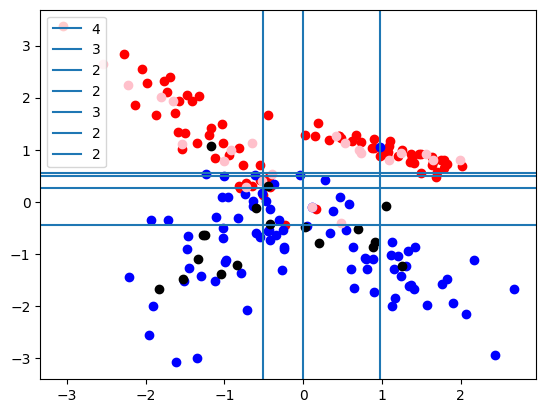

{'f': 1,
 'value': 0.2572553887229898,
 'left': {'f': 1,
  'value': -0.4479435521148749,
  'left': {'f': 0,
   'value': 0,
   'left': {'f': -1, 'class': 0, 'p': 0.0},
   'right': {'f': -1, 'class': 0, 'p': 0.0}},
  'right': {'f': 0,
   'value': -0.5121934912657302,
   'left': {'f': -1, 'class': 0, 'p': 0.0},
   'right': {'f': -1, 'class': 0, 'p': 0.8812908992306927}}},
 'right': {'f': 1,
  'value': 0.5574713071691777,
  'left': {'f': 1,
   'value': 0.4988841438379208,
   'left': {'f': -1, 'class': 1, 'p': 0.7219280948873623},
   'right': {'f': -1, 'class': 0, 'p': 0.0}},
  'right': {'f': 0,
   'value': 0.973395876409147,
   'left': {'f': -1, 'class': 1, 'p': 0.0},
   'right': {'f': -1, 'class': 1, 'p': 0.23519338181924143}}}}

In [67]:
import matplotlib.pyplot as plt
sX = sorted(X_train[:, 0])
plt.scatter(X_train[y_train==1][:, 0], X_train[y_train==1][:, 1], color='red')
plt.scatter(X_train[y_train==0][:, 0], X_train[y_train==0][:, 1], color='blue')

sX = sorted(X_test[:, 0])
plt.scatter(X_test[y_test==1][:, 0], X_test[y_test==1][:, 1], color='pink')
plt.scatter(X_test[y_test==0][:, 0], X_test[y_test==0][:, 1], color='black')

def get_tree(X, y, depth):
    f, value = get_best_partition(X, y)
    if depth > 1:
        if f == 0:
            plt.axvline(x=value, label = depth)
        else:
            plt.axhline(y=value, label = depth)
        if len(y[X[:,f] < value]) > 0:
            left_tree = get_tree(X[X[:,f] < value], y[X[:,f] < value], depth - 1)
        else:
            left_tree = {}
        if len(y[X[:,f] >= value]) > 0: 
            right_tree = get_tree(X[X[:,f] >= value], y[X[:,f] >= value], depth - 1)
        else:
            right_tree = {}
        if right_tree=={} or left_tree=={}:
            return {"f":-1, "class":get_result(y)[0], "p" : get_result(y)[1] }
        return {"f" : f, "value" : value, "left" :  left_tree, 
                "right" : right_tree}
    else:
        return {"f" : -1, "class":get_result(y)[0], "p" : get_result(y)[1]}
    
def get_result(y):
    h = H(y)
    classes = np.unique(y, return_counts=True)
    ind = np.argmax(classes[1])
    cl = classes[0][ind]
    return (cl, h)
    
tree = get_tree(X_train, y_train, 4)
plt.legend(loc="upper left")
plt.show()
tree


In [68]:

def predict_item(tree, x):
    if tree['f'] != -1:
        ind = tree['f']
        if x[ind] < tree['value']:
            return predict_item(tree['left'], x)
        else:
            return predict_item(tree['right'], x)
    else:
        return tree['class']

def predict(tree, X):
    y_pred = []
    for x in X:
        yi = predict_item(tree, x)
        y_pred.append(yi)
    return y_pred

y_pred = predict(tree, X_test)
accuracy_score(y_test, y_pred)


0.875